In [84]:
import pandas as pd
import numpy as np
import astropy as ap
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [89]:
clusters=pd.read_pickle('/home/cz136/project/sa/data/cluster.pkl')
shapes=pd.read_pickle('/home/cz136/project/sa/data/shape.pkl')

print(len(shapes))

shapes=shapes[shapes[('All','P')]>=0.55]
shapes=shapes[shapes[('All','e1')]!=-9999]
shapes=shapes[shapes[('All','e2')]!=-9999]

clusters[('Alt', 'Alt1', 'P_CEN')]<=0.55

# clusters.drop([202],inplace=True)

print(len(clusters))
print(len(shapes))

394334
7066
246846


In [90]:
poor_index=clusters[clusters[('Alt', 'Alt1', 'P_CEN')]<=0.55][('Alt', 'Alt1', 'P_CEN')].index
clusters.loc[poor_index][[('Alt', 'Alt1', 'ID_CENT')]]

Type,Alt
Kind,Alt1
Data,ID_CENT
"(All, All, MEM_MATCH_ID)",
5,3138662814
32,3082542813
35,3158368426
48,3155802377
73,3093318168
...,...
22513,3041454014


# Get phi 

In [116]:
def get_std_err_of_mean(np_array):
    mean=np_array.mean()
    std=np_array.std()
    n=len(np_array)
    return(std/np.sqrt(n))

In [91]:
def get_theta_for_obj(obj1,obj2):
    ra1,dec1=(obj1[('All', 'RA')],obj1[('All', 'DEC')])
    ra2,dec2=(obj2[('All', 'RA')],obj2[('All', 'DEC')])
    
    
    
    c1=SkyCoord(ra1*u.deg,dec1*u.deg)
    c2=SkyCoord(ra2*u.deg,dec2*u.deg)
    
    
    return(90-c1.position_angle(c2).degree)
    

In [92]:
def get_pa_for_obj(obj):
    e1=obj['All']['e1']
    e2=obj['All']['e1']
    
    α =0.5*np.arctan2(e2,e1)*180/np.pi
    return(α)

In [93]:
error_list_phi=[]
error_list_e=[]

def get_phi_for_cluster(cluster):
    
    
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]



        pa=np.array([get_pa_for_obj(member[1]) for member in members.iterrows()]).flatten()
        theta= np.array([get_theta_for_obj(member[1],center) for member in members.iterrows()]).flatten()
        phi=pa-theta
    #     print(center.index)
        return(phi)    
    except KeyError as e:
        error_list_phi.append(e)
        
        return(np.array([]))

In [94]:
phi_list=[]
for mem_matching_id in tqdm(clusters.index):
    phi_array=get_phi_for_cluster(clusters.loc[mem_matching_id])
    phi_list.append(phi_array)
phi_list=np.array(phi_list)

In [95]:
phi_1d=np.concatenate(phi_list)

phi_1d=np.where(phi_1d<=0,-phi_1d,phi_1d)
phi_1d=np.where(phi_1d>=180,phi_1d-180,phi_1d)
phi_1d=np.where(phi_1d>=90,180-phi_1d,phi_1d)

phi_1d=np.sort(phi_1d)

In [96]:
np.save("/home/cz136/project/sa/data/phi_1d",phi_1d)

In [97]:
phi_1d=np.load("/home/cz136/project/sa/data/phi_1d.npy")
pd.Series(phi_1d).describe()
print(" {} {} ".format(phi_1d.mean(),phi_1d.std()/np.sqrt(len(phi_1d))))

 44.83873691489237 0.055404705014883024 


Text(0.5, 1.0, 'Histogram of $phi_{sat}$')

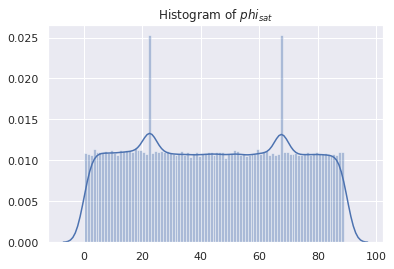

In [99]:
BINS=np.arange(0,90,1)
ax = sns.distplot(phi_1d,bins=BINS)
ax.set_title("Histogram of $phi_{sat}$") 

In [100]:
phi_count=np.histogram(phi_1d,bins=BINS)
sort=np.argsort(-phi_count[0])
print(phi_count[1][sort])
print(phi_count[0][sort])

[67 22 17  3 59 14  9 51 12 19 18 15 26 33 13 52 24 62  7 28 61 88 43 68
 20 45 42 76 87 27 79  5 16 46 35 25 38  4 69 47 37 23 72  8  6 10 50 29
 41 82 78 64  0 70 30 83 60 71 66 81 80 32 40 49 21 75 85 57 54  1 58 11
 86 56 34 74  2 53 65 73 63 77 31 44 55 39 84 36 48]
[5467 5462 2487 2456 2453 2447 2438 2437 2429 2425 2424 2422 2421 2417
 2417 2417 2416 2415 2408 2407 2403 2397 2395 2392 2386 2385 2385 2383
 2382 2381 2380 2380 2378 2378 2378 2377 2375 2375 2374 2371 2367 2367
 2362 2361 2360 2357 2357 2351 2350 2350 2349 2348 2347 2343 2343 2342
 2342 2340 2339 2338 2334 2331 2331 2328 2327 2326 2325 2325 2324 2319
 2319 2317 2316 2315 2314 2314 2312 2312 2312 2310 2306 2305 2300 2299
 2287 2285 2276 2250 2214]


count    5467.000000
mean       22.499803
std         0.189165
min        22.000249
25%        22.500000
50%        22.500000
75%        22.500000
max        23.002244
dtype: float64

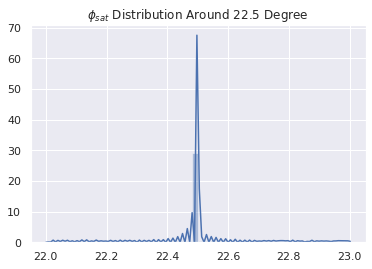

In [101]:
first_cluster_left=np.sum(phi_count[0][0:22])
first_length=phi_count[0][sort][0]
first_cluster=phi_1d[first_cluster_left:first_cluster_left+first_length]
ax = sns.distplot(first_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 22.5 Degree")
pd.Series(first_cluster).describe()

count    5467.000000
mean       67.496044
std         0.188971
min        67.000313
25%        67.500000
50%        67.500000
75%        67.500000
max        67.999623
dtype: float64

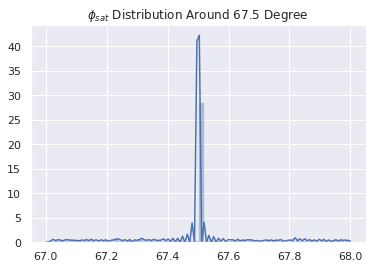

In [102]:
second_cluster_left=np.sum(phi_count[0][0:67])
second_length=phi_count[0][sort][0]
second_cluster=phi_1d[second_cluster_left:second_cluster_left+second_length]
ax = sns.distplot(second_cluster)
ax.set_title("$\phi_{sat}$ Distribution Around 67.5 Degree")
pd.Series(second_cluster).describe()

# Get e

In [103]:
e1=shapes[('All','e1')].to_numpy()
shapes[('All','e1')].describe()

count    246846.000000
mean          0.000067
std           0.148725
min          -0.988648
25%          -0.079861
50%          -0.000124
75%           0.079938
max           0.977076
Name: (All, e1), dtype: float64

In [104]:
e2=shapes[('All','e1')].to_numpy()
shapes[('All','e2')].describe()

count    246846.000000
mean         -0.000339
std           0.149611
min          -0.845018
25%          -0.081397
50%          -0.000354
75%           0.080591
max           0.902807
Name: (All, e2), dtype: float64

In [105]:
np.histogram(e1,bins=np.arange(-10000,10000,1))

(array([0, 0, 0, ..., 0, 0, 0]),
 array([-10000,  -9999,  -9998, ...,   9997,   9998,   9999]))

In [106]:
def get_e_for_pair(cen,sat):
    e=np.sqrt(sat[('All','e1')]**2+sat[('All','e2')]**2)
    delta=get_theta_for_obj(cen,sat)
    alpha=get_pa_for_obj(sat)
    ep,ex=(e*np.cos(2*(delta-alpha)),e*np.sin(2*(delta-alpha)))
    return(ep,ex)

In [107]:
def get_e_for_cluster(cluster):
    
    try:
        center_id=cluster[('Alt', 'Alt1', 'ID_CENT')]
        center = shapes.loc[center_id]

        mem_match_id=cluster.name
        members=shapes[shapes['All','MEM_MATCH_ID']==mem_match_id]

        e_array=np.array([(get_e_for_pair(center,member[1])) for member in members.iterrows()])
        return(e_array)    
    except KeyError as e:
        error_list_e.append(e)
        return(np.array([]))

In [108]:
e_list=[]
for mem_matching_id in tqdm(clusters.index[:]):
    e_array=get_e_for_cluster(clusters.loc[mem_matching_id])
    e_list.append(e_array)
e_list=np.array(e_list)
e_list=np.concatenate([e_array for e_array in e_list if e_array!=np.array([])])

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


In [115]:
np.save("/home/cz136/project/sa/data/e_array",e_list)

In [112]:
e_p_1d=e_list[:,0].flatten()
e_x_1d=e_list[:,1].flatten()

0.00016360630899306953 0.00031882591714042915


count    218615.000000
mean          0.000164
std           0.149071
min          -0.994047
25%          -0.081283
50%           0.000382
75%           0.081155
max           0.818467
dtype: float64

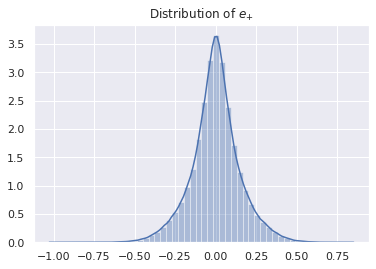

In [121]:
ax=sns.distplot(e_p_1d)
ax.set_title("Distribution of $e_{+}$")
print (e_p_1d.mean(),get_std_err_of_mean(e_p_1d))
pd.Series(e_p_1d).describe()

0.0012078086698508917 0.0003182885671637121


count    218615.000000
mean          0.001208
std           0.148820
min          -0.908880
25%          -0.078641
50%           0.003337
75%           0.081043
max           0.939512
dtype: float64

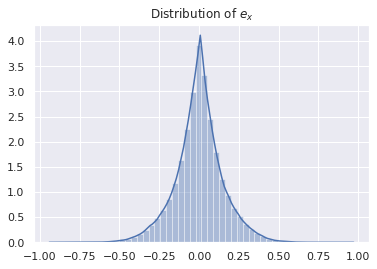

In [122]:
ax=sns.distplot(e_x_1d)
ax.set_title("Distribution of $e_{x}$")
print (e_x_1d.mean(),get_std_err_of_mean(e_x_1d))
pd.Series(e_x_1d).describe()